# World Bank Population Database and Analysis

*Showcasing Python's ability to wrangle and extract data from relational databases using advanced SQL. Combining Type 1 and Type 2 nested SQL queries and Python libraries to analyze global population data stored in PostgreSQL. Please refer to [wdi_db_creation.sql](https://github.com/mgcruz024/wdi-population/blob/a5ef97147f9f84103438279e727bbc66c43531f9/wdi_db_creation.sql) for World Bank DB creation.*

<img src="Screenshots/population_map.png" alt="Population Map">


## Data Dictionary

Main population indicators:
    
    1.EN_URB_LCTY.csv = population in largest city (1960-2018)
    2.SP_POP_TOTL.csv = population, total (1950-2018)
    3.SP_URB_TOTL.csv = Urban Population (1950-2018)
    4.SP_URB_GROW.csv = Urban population growth (annual %) (1951-2018)
    5.SM_POP_NETM.csv = Net migration (1952-2017)
    
Additional population indicators:

    6.IS_AIR_PSGR.csv = Air transport, passengers carried
    7.NY_GDP_MKTP_CD.csv = GDP (current USD)
    8.NY_GDP_PCAP_CD.csv = GDP per capita (current USD)
    9.SH_MED_BEDS_ZS.csv = Hospital beds (per 1,000 people)
    10.FP_CPI_TOTL_ZG.csv = Inflation, consumer prices (annual %)
    11.IT_NET_USER_P2.csv = Internet users (per 100 people)

## Establishing a connection with our  PostgreSQL db and running queries via psycopg2

In [49]:
#pip install psycopg2
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

In [3]:
conn = psycopg2.connect(database = "wdi", 
                        user = "wdi_read_user", 
                        host= 'localhost',
                        password = "read_world",
                        port = 5432)

cur = conn.cursor()

In [4]:
# Function that creates df's for SQL queries  

def query_df(query,column_names):
    cur.execute(query)
    return pd.DataFrame(data=cur.fetchall(),columns=column_names)


### M1: Countries that do not have any data for any of the indicators.

In [6]:
M1_query = """select name
from (
        SELECT DISTINCT country.name
        FROM country
        WHERE country.name NOT IN (SELECT DISTINCT country.name
        FROM country LEFT JOIN country_data ON country_data.country_code = country.code
        WHERE country_data.indicator_code = 'EN_URB_LCTY')
        UNION
        SELECT DISTINCT country.name
        FROM country
        WHERE country.name NOT IN (SELECT DISTINCT country.name
        FROM country LEFT JOIN country_data ON country_data.country_code = country.code
        WHERE country_data.indicator_code = 'SP_POP_TOTL')
        UNION
        SELECT DISTINCT country.name
        FROM country
        WHERE country.name NOT IN (SELECT DISTINCT country.name
        FROM country LEFT JOIN country_data ON country_data.country_code = country.code
        WHERE country_data.indicator_code = 'SP_URB_TOTL')
        UNION
        SELECT DISTINCT country.name
        FROM country
        WHERE country.name NOT IN (SELECT DISTINCT country.name
        FROM country LEFT JOIN country_data ON country_data.country_code = country.code
        WHERE country_data.indicator_code = 'SP_URB_GROW')
        UNION
        SELECT DISTINCT country.name
        FROM country
        WHERE country.name NOT IN (SELECT DISTINCT country.name
        FROM country LEFT JOIN country_data ON country_data.country_code = country.code
        WHERE country_data.indicator_code = 'SM_POP_NETM') ) as got
        order by name;"""

M1_df = query_df(M1_query,['Countries'])
M1_df.head(10)

,Countries
0,American Samoa
1,Andorra
2,Antigua and Barbuda
3,Aruba
4,"Bahamas, The"
5,Barbados
6,Belize
7,Bermuda
8,Bhutan
9,Botswana


There are 60 country that do not have any data for population. Worth investigating the possible 
reasons for these missing values. 

### M2: Countries that have data for all of the indicators. 

In [69]:
M2_query = """SELECT DISTINCT country.name
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'EN_URB_LCTY'
    INTERSECT
SELECT DISTINCT country.name
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SP_POP_TOTL'
INTERSECT
SELECT DISTINCT country.name
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SP_URB_TOTL'
INTERSECT
SELECT DISTINCT country.name
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SP_URB_GROW'
INTERSECT
SELECT DISTINCT country.name
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SM_POP_NETM'
ORDER BY name;"""

M2_df = query_df(M2_query,['Countries'])
M2_df

,Countries
0,Afghanistan
1,Albania
2,Algeria
3,Angola
4,Argentina
...,...
148,Vietnam
149,West Bank and Gaza
150,"Yemen, Rep."
151,Zambia


In contrast, there are 153 countries that have data for all of our indicators. Worth investigating the commonalities for those
with populated data.

### M3: Indicators with the corresponding number of countries with data, sorted in the descending order of the number of countries.

In [70]:
M3_query = """select indicator.code, indicator.description, COUNT (DISTINCT country_code) AS countries
FROM indicator INNER JOIN country_data ON code = country_data.indicator_code
WHERE indicator.code IN ('EN_URB_LCTY', 'SM_POP_NETM', 'SP_POP_TOTL', 'SP_URB_GROW', 'SP_URB_TOTL')
GROUP BY indicator.description, indicator.code
ORDER BY countries DESC;"""

M3_df = query_df(M3_query,['Code','Description','Countries'])
M3_df

,Code,Description,Countries
0,SP_POP_TOTL,"Population, total (1950-2018)",213
1,SP_URB_GROW,Urban population growth (annual %)(1951-2018),211
2,SP_URB_TOTL,Urban population (1950-2018),211
3,SM_POP_NETM,Net migration (1952-2017),193
4,EN_URB_LCTY,Population in largest city (1960-2018),153


### M4: Top 10 countries in terms of the most recent value of population total.

In [84]:
M4_query = """SELECT date, country.name, value
FROM country_data INNER JOIN country ON country.code = country_data.country_code
WHERE country_data.indicator_code = 'SP_POP_TOTL' AND date = (SELECT MAX(country_data.date) FROM country_data WHERE country_data.indicator_code = 'SP_POP_TOTL')
GROUP BY date, country.name, value
ORDER BY value DESC
LIMIT 10;"""

M4_df = query_df(M4_query,['Date','Name','Value'])
M4_df['Value'] = (M4_df['Value'] / 10).astype('int32')
M4_df

,Date,Name,Value
0,2018-12-31,China,139273000
1,2018-12-31,India,135261732
2,2018-12-31,United States,32668750
3,2018-12-31,Indonesia,26766343
4,2018-12-31,Pakistan,21221503
5,2018-12-31,Brazil,20946933
6,2018-12-31,Nigeria,19587474
7,2018-12-31,Bangladesh,16135603
8,2018-12-31,Russian Federation,14447805
9,2018-12-31,Japan,12652910


### M5: Continents with the corresponding most recent average value (computed across countries with data) of population total. 

In [59]:
M5_query = """SELECT date, continent.name, round(100*AVG(country_data.value))/100 as avg_pop
FROM continent INNER JOIN continent_country ON continent_country.continent_code = continent.code
INNER JOIN country ON country.code = continent_country.country_code
INNER JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SP_POP_TOTL' AND date = (SELECT MAX(country_data.date) FROM country_data WHERE country_data.indicator_code = 'SP_POP_TOTL')
GROUP BY date, continent.name 
ORDER BY continent.name;"""


M5_df = query_df(M5_query,['Date','Name','Avg_Pop'])
M5_df

,Date,Name,Avg_Pop
0,2018-12-31,Africa,23976180.89
1,2018-12-31,Asia,91255786.94
2,2018-12-31,Australia and Oceania,2317473.39
3,2018-12-31,Europe,16614773.94
4,2018-12-31,North America,17630119.18
5,2018-12-31,South America,35283249.58


6 out of the 7 continents have available data. Antarctica is unavailable (expected).

### M6: All of the indicators in a table of values for the United States.



In [60]:
M6_query = """select dat.date, dat.value as sp_pop_totl, mat.value as sp_urb_totl, cat.value as sp_urb_grow, pat.value as en_urb_lcty, bat.value as sm_pop_netm
 from
 (select country_data.date, country_data.value from country_data where country_data.country_code = 'USA' and country_data.indicator_code  = 'SP_POP_TOTL' group by country_data.date, country_data.value) as dat
 full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'USA' and country_data.indicator_code  = 'SP_URB_TOTL' group by country_data.date, country_data.value) as mat on dat.date = mat.date
 full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'USA' and country_data.indicator_code  = 'SP_URB_GROW' group by country_data.date, country_data.value) as cat on mat.date = cat.date
 full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'USA' and country_data.indicator_code  = 'EN_URB_LCTY' group by country_data.date, country_data.value) as pat on cat.date = pat.date
 full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'USA' and country_data.indicator_code  = 'SM_POP_NETM' group by country_data.date, country_data.value) as bat on dat.date = bat.date
 order by dat.date;"""

M6_df = query_df(M6_query,['Date','SP_POP_TOTL','SP_URB_TOTL','SP_URB_GROW','EN_URB_LCTY','SM_POP_NETM'])
M6_df

,Date,SP_POP_TOTL,SP_URB_TOTL,SP_URB_GROW,EN_URB_LCTY,SM_POP_NETM
0,1950-12-31,152271000.0,97686415.0,NaN,NaN,NaN
1,1951-12-31,154910120.0,100327539.0,2.667772,NaN,NaN
2,1952-12-31,157594980.0,103024566.0,2.652724,NaN,960424.0
3,1953-12-31,160326373.0,105775325.0,2.634980,NaN,NaN
4,1954-12-31,163105107.0,108582332.0,2.619144,NaN,NaN
...,...,...,...,...,...,...
64,2014-12-31,318301008.0,259361210.0,0.953587,18590808.0,NaN
65,2015-12-31,320635163.0,261865944.0,0.961099,18647626.0,NaN
66,2016-12-31,322941311.0,264366216.0,0.950262,18704696.0,NaN
67,2017-12-31,324985539.0,266676634.0,0.870149,18761941.0,4774029.0


All indicator values are put into respective rows for each year; not all indicators have values for each year. 

SP_POP_TOTL (1950-2018), SP_URB_TOTL (1950-2018), SP_URB_GROW (1951-2018), EN_URB_LCTY (1960-2018), SM_POP_NETM (1952-2017).

### M7: Average % population growth for each country for all years 2010 and later.



In [61]:
M7_query = """ SELECT name, round(AVG(GROWTH.pct_growth)::numeric, 4) as avg_pct_growth
FROM 
(
SELECT *, CD1.value/CD0.value-1.0 as pct_growth, CD1.country_code cc FROM  
(SELECT *,
(SELECT MAX(CD.date)
 FROM country_data CD
 WHERE CD.country_code=country_data.country_code AND
CD.indicator_code=country_data.indicator_code
 AND CD.date<country_data.date
 ) prev_date
FROM country_data) CD1
INNER JOIN country_data CD0 ON
CD0.country_code=CD1.country_code AND CD0.indicator_code=CD1.indicator_code
AND CD0.date=CD1.prev_date
WHERE CD0.indicator_code='SP_URB_TOTL'
AND CD1.country_code IN
(SELECT country_code
 FROM country_data WHERE indicator_code='SP_URB_TOTL'
 AND date >= '2009-12-31'
GROUP BY country_code
)
AND CD1.date >= '2010-12-31'
) GROWTH INNER JOIN country ON code=GROWTH.cc
GROUP BY name
ORDER BY avg_pct_growth DESC;"""

M7_df = query_df(M7_query,['Name','Avg_Pct_Growth'])
M7_df

,Name,Avg_Pct_Growth
0,Eritrea,0.0872
1,Oman,0.0742
2,Uganda,0.0616
3,Qatar,0.0608
4,Burundi,0.0587
...,...,...
206,Latvia,-0.0111
207,Andorra,-0.0112
208,Lithuania,-0.0120
209,Puerto Rico,-0.0177


### M8: Countries which have 2011 data for all indicators.

In [62]:
M8_query = """SELECT date, country.name, COUNT (*)
FROM country INNER JOIN country_data ON country_data.country_code = country.code
WHERE EXTRACT(YEAR FROM date) = 2011 AND country_data.indicator_code IN ('EN_URB_LCTY', 'SM_POP_NETM',
'SP_POP_TOTL', 'SP_URB_GROW', 'SP_URB_TOTL')
GROUP BY date, country.name
HAVING COUNT (*) = 5;"""

M8_df = query_df(M8_query,['Date','Name','Count'])
M8_df

,Date,Name,Count


There are 0 country names in the table, which means every country since 2011 has a missing value for at least one of the indicators.

### M9: All indicators in a table of values for Japan since the earliest record.



In [81]:
M9_query = """select dat.date, dat.value as sp_pop_totl, mat.value as sp_urb_totl, cat.value as sp_urb_grow, pat.value as en_urb_lcty, bat.value as sm_pop_netm
from
(select country_data.date, country_data.value from country_data where country_data.country_code = 'JPN' and country_data.indicator_code  = 'SP_POP_TOTL' group by country_data.date, country_data.value) as dat
full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'JPN' and country_data.indicator_code  = 'SP_URB_TOTL' group by country_data.date, country_data.value) as mat on dat.date = mat.date
full join (select country_data.date, country_data.value from country_data where country_data.country_code = 'JPN' and country_data.indicator_code  = 'SP_URB_GROW' group by country_data.date, country_data.value) as cat on mat.date = cat.date
join (select country_data.date, country_data.value from country_data where country_data.country_code = 'JPN' and country_data.indicator_code  = 'EN_URB_LCTY' group by country_data.date, country_data.value) as pat on cat.date = pat.date
join (select country_data.date, country_data.value from country_data where country_data.country_code = 'JPN' and country_data.indicator_code  = 'SM_POP_NETM' group by country_data.date, country_data.value) as bat on dat.date = bat.date
order by dat.date;"""

M9_df = query_df(M9_query,['Date','SP_POP_TOTL','SP_URB_TOTL','SP_URB_GROWTH','EN_URB_LCTY','SM_POP_NETM'])
M9_df

,Date,SP_POP_TOTL,SP_URB_TOTL,SP_URB_GROWTH,EN_URB_LCTY,SM_POP_NETM
0,1962-12-31,95832000.0,62428798.0,2.371446,18036396.0,-151351.0
1,1967-12-31,100725000.0,70019991.0,2.107557,21478943.0,822703.0
2,1972-12-31,107188000.0,78731730.0,2.476633,24574388.0,714937.0
3,1977-12-31,113863000.0,86538157.0,1.040019,27426678.0,205006.0
4,1982-12-31,118449000.0,90474900.0,0.822653,29244389.0,50002.0
5,1987-12-31,122091000.0,93963675.0,0.656978,31163888.0,-298339.0
6,1992-12-31,124229000.0,96414127.0,0.424917,32990378.0,46286.0
7,1997-12-31,126057000.0,98667335.0,0.400657,33934040.0,-100333.0
8,2002-12-31,127445000.0,104055019.0,2.282872,34904446.0,164199.0
9,2007-12-31,128001000.0,112827761.0,1.288009,36111394.0,277580.0


### M10: Relation between the inflation rate and GDP per capita in the USA between 1960 and 2019.

In [15]:
M10_query_inflation = """SELECT date as date, value as inflation, country_code, indicator_code FROM country_data
WHERE country_code = 'USA' AND date between '1960-12-31' AND '2018-12-31'
AND country_data.indicator_code = 'FP_CPI_TOTL_ZG'
order by date;"""

M10_query_gdp_per_c = """SELECT date as DATE, value as GDP_Per_C, country_code, indicator_code FROM country_data
WHERE country_code = 'USA' AND date between '1960-12-31' AND '2018-12-31'
and country_data.indicator_code = 'NY_GDP_PCAP_CD'
order by date;"""

M10_query_inflation_df = query_df(M10_query_inflation,['Date','Inflation','COUNTRY_CODE','INDICATOR_CODE'])
M10_query_gdp_per_c_df = query_df(M10_query_gdp_per_c,['Date','GDP_PER_C','COUNTRY_CODE','INDICATOR_CODE'])

In [16]:
new_series = M10_query_inflation_df['Inflation']
M10_query_gdp_per_c_df['Inflation'] = new_series
M10_query_gdp_per_c_df = M10_query_gdp_per_c_df[['Date', 'GDP_PER_C', 'Inflation','COUNTRY_CODE', 'INDICATOR_CODE']]

In [17]:
M10_query_gdp_per_c_df.head(10)

,Date,GDP_PER_C,Inflation,COUNTRY_CODE,INDICATOR_CODE
0,1960-12-31,3007.123445,1.457976,USA,NY_GDP_PCAP_CD
1,1961-12-31,3066.562869,1.070724,USA,NY_GDP_PCAP_CD
2,1962-12-31,3243.843078,1.198773,USA,NY_GDP_PCAP_CD
3,1963-12-31,3374.515171,1.239669,USA,NY_GDP_PCAP_CD
4,1964-12-31,3573.941185,1.278912,USA,NY_GDP_PCAP_CD
5,1965-12-31,3827.527110,1.585169,USA,NY_GDP_PCAP_CD
6,1966-12-31,4146.316646,3.015075,USA,NY_GDP_PCAP_CD
7,1967-12-31,4336.426587,2.772786,USA,NY_GDP_PCAP_CD
8,1968-12-31,4695.923390,4.271796,USA,NY_GDP_PCAP_CD
9,1969-12-31,5032.144743,5.462386,USA,NY_GDP_PCAP_CD


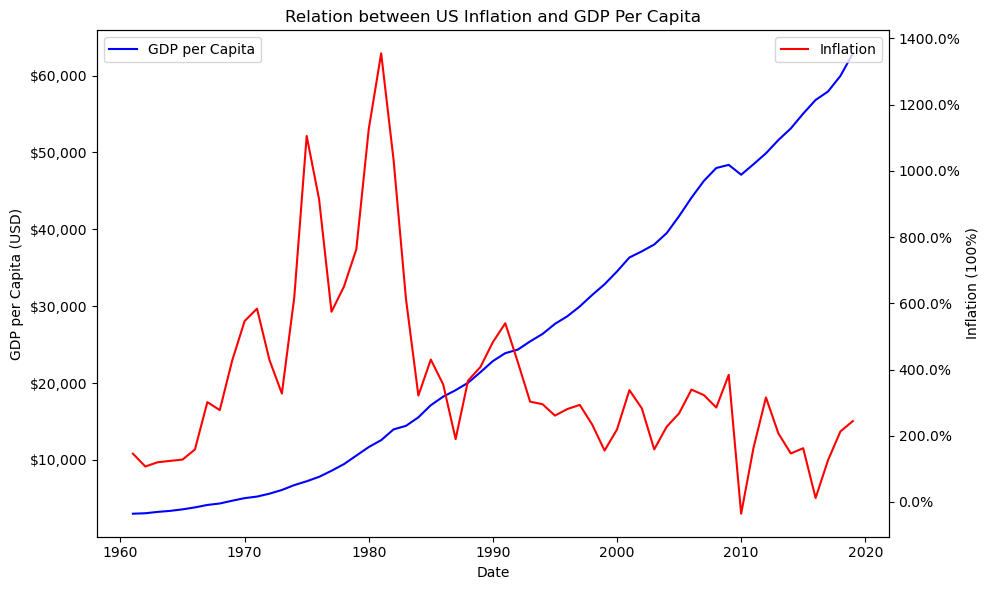

In [52]:
# Standardize Inflation to fit graph
y_inflation = 100 * M10_query_gdp_per_c_df['Inflation']

# Create line chart with dual Y-axes using Seaborn
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GDP per Capita on the left Y-axis
sns.lineplot(x='Date', y='GDP_PER_C', data=M10_query_gdp_per_c_df, ax=ax1, label='GDP per Capita', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP per Capita (USD)')
ax1.tick_params('y')

# Create a secondary Y-axis for Inflation
ax2 = ax1.twinx()
sns.lineplot(x='Date', y=y_inflation, data=M10_query_gdp_per_c_df, ax=ax2, label='Inflation', color='red')
ax2.set_ylabel('Inflation (100%)')
ax2.tick_params('y')

# Set y-axis labels as dollars and percentages
formatter_dollar = FuncFormatter(lambda x, _: f'${x:,.0f}')
ax1.yaxis.set_major_formatter(formatter_dollar)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Set title
plt.title('Relation between US Inflation and GDP Per Capita')

# Show legend
fig.tight_layout()
#fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

The data trends between 1960 and 2018 show a weak negative correlation between GDP and inflation. Suggests other variables that could cause the fluctuation of GDP besides inflation.

### M11: Total population by country in 2018, ordered top population.

In [85]:
M11_query = """SELECT DISTINCT country.name, country_data.value
FROM country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE country_data.indicator_code = 'SP_POP_TOTL' AND
date = '2018-12-31'
order by country_data."value" DESC;"""

M11_df = query_df(M11_query,['Name','Value'])
M11_df['Value'] = (M11_df['Value'] / 1).astype('int32')
M11_df.head(10)

,Name,Value
0,China,1392730000
1,India,1352617328
2,United States,326687501
3,Indonesia,267663435
4,Pakistan,212215030
5,Brazil,209469333
6,Nigeria,195874740
7,Bangladesh,161356039
8,Russian Federation,144478050
9,Japan,126529100


### M12: Net migration change in the last 17 years for every country (displaying the changes every year).

In [133]:
M12_query = """SELECT DISTINCT country.name, max(country_data.value) as Largest_Migration, country_data.date
FROM  country LEFT JOIN country_data ON country_data.country_code = country.code
WHERE indicator_code ='SM_POP_NETM' AND date > '2000-01-01'
GROUP BY country.name, country_data.date
ORDER BY country_data.date DESC;"""

M12_df = query_df(M12_query,['Name','Net_Migration_Change','Date'])
M12_df.head(10)

,Name,Net_Migration_Change,Date
0,Afghanistan,-314602.0,2017-12-31
1,Albania,-69998.0,2017-12-31
2,Algeria,-50002.0,2017-12-31
3,Angola,32066.0,2017-12-31
4,Antigua and Barbuda,0.0,2017-12-31
5,Argentina,24000.0,2017-12-31
6,Armenia,-24989.0,2017-12-31
7,Aruba,1004.0,2017-12-31
8,Australia,791229.0,2017-12-31
9,Austria,324998.0,2017-12-31


### M13: Average total Population in Africa between 1990 & 2000

In [87]:
M13_query = """SELECT DISTINCT continent.name, avg(country_data.value) as Total_Population
FROM continent LEFT JOIN continent_country ON continent_country.continent_code = continent.code
LEFT JOIN country ON country.code = continent_country.country_code
LEFT JOIN country_data ON country_data.country_code = country.code
WHERE continent.name ='Africa' AND country_data.date BETWEEN '1990-01-01' AND '2000-12-31'
AND country_data.indicator_code ='SP_URB_TOTL'
GROUP BY continent.name;"""

M13_df = query_df(M13_query,['Name','Total_Population'])
M13_df['Total_Population'] = (M13_df['Total_Population'] / 1).astype('int32')

M13_df.head(10)

,Name,Total_Population
0,Africa,4434678


### Close cursor and connection with WDI Database

In [88]:
cur.close()
conn.close()